# Node2Vec

In [1]:
"""
@author: vatsal
"""

import networkx as nx
import pandas as pd
import random

from node2vec import Node2Vec as n2v
from itertools import combinations, groupby

## Generate Data

## Create Graph

In [2]:
def generate_graph(n, p, dt = nx.MultiGraph()):
    '''
    This function will generate a graph G based on the users input parameters
    
    params:
        n (Integer) : The number of nodes you would like in the graph
        p (Float) : The probability of adding an edge between nodes
        dt (Function) : The type of the graph you want to create
    '''
    edges = combinations(range(n), 2)
    G = dt
    G.add_nodes_from(range(n))
    
    if p <= 0:
        return G
    elif p >= 1:
        return nx.complete_graph(n, create_using = G)
    else:
        for _, ne in groupby(edges, key = lambda x : x[0]):
            ne = list(ne)
            re = random.choice(ne)
            G.add_edge(*re)
            for e in ne:
                if random.random() < p:
                    G.add_edge(*e)
    return G

In [3]:
G = generate_graph(n = 1000, p = 0.2, dt = nx.MultiGraph())

In [4]:
print(nx.info(G))

Name: 
Type: MultiGraph
Number of nodes: 1000
Number of edges: 100927
Average degree: 201.8540


## Node2Vec

**Parameter Info**  
- graph: a graph g, where all nodes must be integers or strings  
- dimensions: embedding dimensions (default: 128)  
- walk_length: number of nodes in each walk (default: 80)  
- num_walks: number of walks per node (default: 10)  
- weight_key: the key for the weight attribute on weighted graphs (default: 'weight')  
- workers: number of workers for parallel execution (default: 1)

Node2Vec.fit method: Accepts any key word argument acceptable by gensim.Word2Vec

In [5]:
%time g_emb = n2v(G, dimensions=16, weight_key='weight')

Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:26<00:00,  2.67s/it]

CPU times: user 2min 4s, sys: 843 ms, total: 2min 5s
Wall time: 2min 5s


In [6]:
WINDOW = 1 # Node2Vec fit window
MIN_COUNT = 1 # Node2Vec min. count
BATCH_WORDS = 4 # Node2Vec batch words

In [7]:
mdl = g_emb.fit(
    window=WINDOW,
    min_count=MIN_COUNT,
    batch_words=BATCH_WORDS
)

## Convert to DataFrame

In [8]:
emb_df = (
    pd.DataFrame(
        [mdl.wv.get_vector(str(n)) for n in G.nodes()],
        index = G.nodes
    )
)

In [9]:
emb_df.iloc[:,1:]

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-0.373687,-0.243872,1.393979,0.471170,0.739675,-0.139760,0.334174,-0.142418,0.326759,0.100043,0.620266,0.406464,-0.185251,-0.095283,0.008244
1,-0.121849,-0.051252,0.848198,0.558151,0.267482,-0.270632,-0.234571,0.032219,-0.101319,-0.274814,-0.616425,-0.072386,-0.602413,0.226133,0.311004
2,-0.197214,0.524244,0.942619,0.527721,0.137883,-0.242701,0.292256,-0.306390,-0.075525,0.497902,0.073505,-0.138331,0.029609,0.536798,0.634288
3,-0.799476,0.283710,0.465149,0.060543,0.548274,-1.193931,-0.354129,-0.174726,0.210599,0.098153,0.944119,-0.033638,0.081945,0.761101,-0.238847
4,-0.520293,0.397295,0.635943,-0.312581,0.414951,-0.188583,-0.536188,-0.161202,-0.189298,0.242789,-0.385271,0.151876,-0.207161,0.745977,0.129091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.288877,0.116052,0.801280,0.471495,0.055168,0.315957,-0.298977,0.170339,0.000518,0.498167,-0.418570,0.219552,0.094672,0.168527,1.102022
996,0.285503,-0.224211,0.246311,0.467777,0.742814,-0.487091,-0.720853,-0.409480,0.651323,0.426083,0.148916,0.051157,0.524718,0.302846,-0.092574
997,-0.452538,-0.298159,0.585532,-0.282106,-0.080808,0.046587,0.225331,-1.217435,0.213461,-0.107644,-0.934281,0.516892,0.051663,0.793922,0.036518
998,0.234434,-0.876906,0.574354,0.740636,0.505751,-0.239521,-0.586027,0.175777,-0.362544,0.377159,0.366973,0.300489,-0.567901,0.936034,-0.184362


In [10]:
import matplotlib.pyplot as plt

### Visualize Embedding

<Figure size 432x288 with 0 Axes>

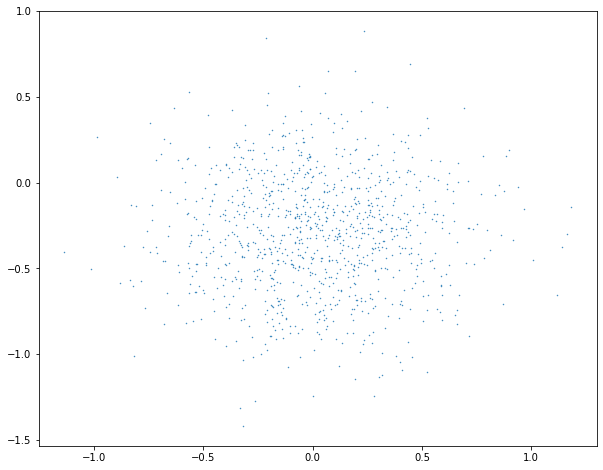

In [11]:
plt.clf()
fig=plt.figure(figsize=(10,8))
plt.scatter(
    x = emb_df.iloc[:,0],
    y = emb_df.iloc[:,1],
    s = 0.2
)
plt.show()
